### !!! Use sweep312 kernel (python 3.12) !!!

## Import Dependencies

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from PSlim import Experiment, get_eps, ROC, ROCAUC

In [2]:
Train = True # False if you do analysis with given simulations and estimates
pyslurm = None  # instead of '/home/enes/pyslurm/'
srun = None
srun_est = None


In [3]:
# if pyslurm:
#     sys.path.append(pyslurm)
#     from pyslurm import Slurm

#     slurm = Slurm(account='stats_dept1')

#     srun = slurm.batch('source activate slim', 
#                        '#time=0-1:00:00',
#                        '#mem=1000M',
#                        '#mem-per-cpu=None', 
#                        '#job-name="sim"')   

#     srun_est = slurm.batch('module load python3.8-anaconda/2020.07', 
#                            '#mem-per-cpu=300',
#                            '#job-name="est"',
#                            '#cpus-per-task=3')

## Set Parameters

In [4]:
N = 50
Ne = 10000
L = 100000
r = 1.25e-8
mu = 2.5e-8

extmut = 0 # no extra mutation (just one)
Until = 100000 # make sure model runs until it reaches the desired frequency Until>>Ne
h = 0.5

Args = {}

Args['Fn'] = {'Simulator':'slim', 'slimTxt':'Slim.txt', 
              'N':N, 'Ne':Ne, 'L':L, 'r':r, 'mu':mu, 
              's':0, 'h':0.5, 'extmut':0, 'reset_lost': 0,
              'Until':Ne, 'Freq':0.25, 'rep':0, 
              'srun':srun, 'srun_est':srun_est,
              'etapath':'etas/Fn.json', 'start': Until + 100,
              'name':'Neutral Model'}

for s in [0.02, 0.01, 0.003, 0.001]:
    for Freq in [0.25, 0.5, 0.75]:
        name = 's='+str(s)+'F='+str(Freq)
        arg = Args['Fn'].copy()
        arg['s'] = s
        arg['Freq'] = Freq
        arg['Until'] = 300000
        arg['name'] = name
        arg['reset_lost'] = 1
        Args[name] = arg

In [5]:
cID = 3 # simulation class id for directional selection constant pop size simulations
nrep = 10 # For initial testing
X = Experiment(cID, nrep, Args)

## Simulate Trees (Skip and Use Cached Results unless first time)

In [6]:
if Train:
    X.sim()

running setid: Fn
pslim set up for Fn
commands set up
running cmd1
running cmd with _run: ['slim', '-s', '3000000', '-d', 'simID=3000000', 'slimfiles/Slim_Neutral_Model.slim']
// Initial random seed:
3000000

// RunInitializeCallbacks():
initializeTreeSeq();
initializeMutationRate(0);
initializeMutationType(1, 0.5, "f", 0);
initializeMutationType(3, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 100000);
initializeRecombinationRate(1.25e-08);

// Starting run at tick <start>:
1 

progress: tick=1000
progress: tick=2000
progress: tick=3000
progress: tick=4000
progress: tick=5000
progress: tick=6000
progress: tick=7000
progress: tick=8000
progress: tick=9000
progress: tick=10000
0.0
cmd with _run done in 33.3s (returncode=0)
running cmd2
running cmd with _run: ['python', 'recap.py', '3000000', '50', '10000', '1.25e-08', '2.5e-08']
recap is starting
/Users/yagishinnosuke/Documents/2025-2026 Stanford/Palacios Lab/Selective-Sweep-Simulation/venv/lib/py

In [7]:
X.calc_sfs()

## Rebuild X From Saved Trees

In [6]:
# Rebuild `X` from on-disk trees (no simulations)
import os, re, json
import numpy as np
import tskit

from PSlim import Experiment  # import from your PSlim.py

# --- your existing Args and cID ---
cID = 3
X = Experiment(cID=cID, nrep=10, Args=Args)   # nrep is a placeholder; we'll overwrite simIDs

TREES_DIR = "trees"  # <- exactly the folder you asked for (relative path: ./trees)

def _matching_paths(regex, folder=TREES_DIR):
    """Return paths like trees/r########.trees that match the regex."""
    r = re.compile(regex)
    files = os.listdir(folder) if os.path.isdir(folder) else []
    return [os.path.join(folder, f) for f in files if r.match(f)]

def _extract_sim_ids(paths):
    """From paths like trees/r3020001.trees or trees/ir3020001.trees, return integer IDs."""
    out = []
    for p in paths:
        m = re.search(r'(\d+)\.trees$', p)
        if m:
            out.append(int(m.group(1)))
    return sorted(set(out))

# Fill in X.simIDs by discovering what’s already on disk (pattern: r{cID}{set_index:02d}{rep:04d}.trees)
for i, setid in enumerate(X.setids):
    regex = f"r{cID}{i:02d}[0-9]{{4}}\\.trees"   # e.g. r300000.trees pattern (escaped dot)
    rpaths = _matching_paths(regex, folder=TREES_DIR)  # returns trees/<filename>
    found_ids = _extract_sim_ids(rpaths)               # just the numeric IDs
    X.simIDs[setid] = found_ids
    if not found_ids:
        print(f"[warn] no r*.trees found for setid={setid} (pattern: {regex})")

# Recompute SFS from the trees we found (fast)
X.calc_sfs()

print("Rebuilt X:")
for sid in X.setids:
    print(f"  {sid}: {len(X.simIDs[sid])} replicates; AFS length={len(X.AFS[sid])}")


Rebuilt X:
  Fn: 11 replicates; AFS length=49
  s=0.02F=0.25: 10 replicates; AFS length=49
  s=0.02F=0.5: 10 replicates; AFS length=49
  s=0.02F=0.75: 10 replicates; AFS length=49
  s=0.01F=0.25: 10 replicates; AFS length=49
  s=0.01F=0.5: 10 replicates; AFS length=49
  s=0.01F=0.75: 10 replicates; AFS length=49
  s=0.003F=0.25: 10 replicates; AFS length=49
  s=0.003F=0.5: 10 replicates; AFS length=49
  s=0.003F=0.75: 10 replicates; AFS length=49
  s=0.001F=0.25: 10 replicates; AFS length=49
  s=0.001F=0.5: 10 replicates; AFS length=49
  s=0.001F=0.75: 10 replicates; AFS length=49


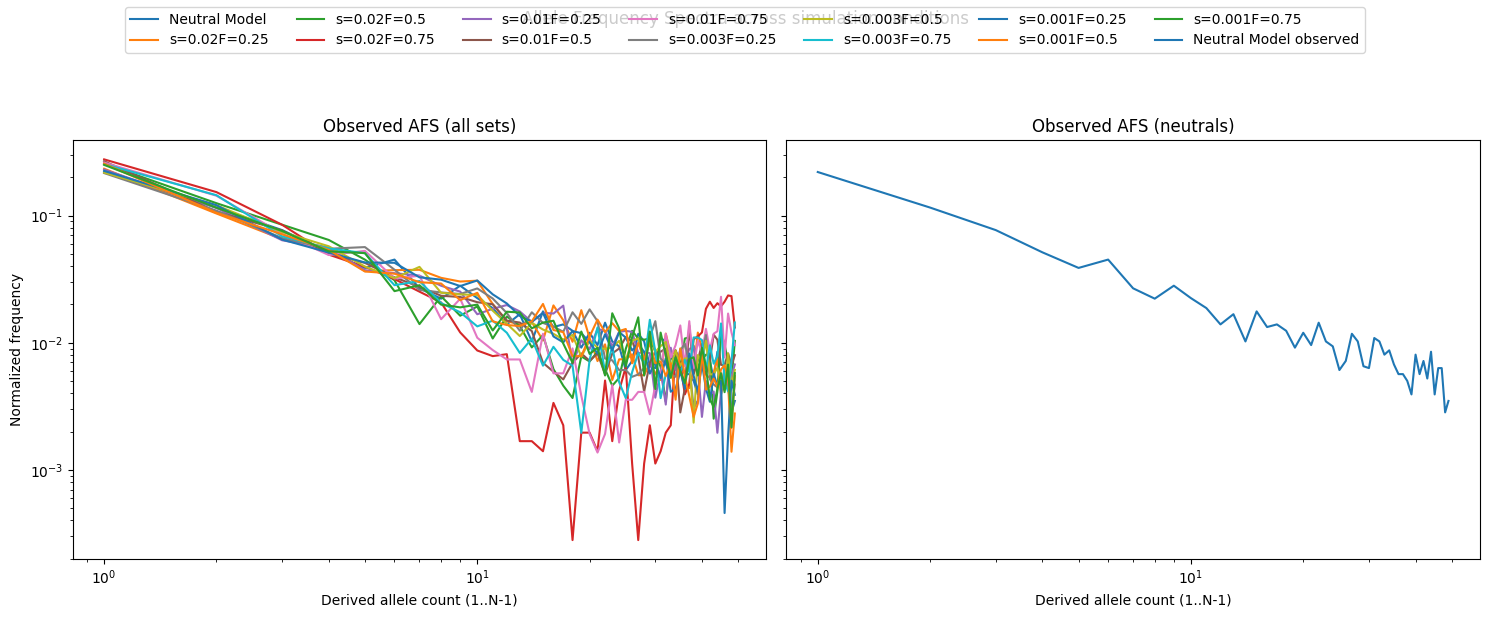

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

# Left panel: all sets' observed AFS
for setid in X.setids:
    name = Args[setid]['name']
    sfs = X.AFS[setid]
    if sfs.sum() == 0:
        continue  # nothing accumulated yet
    x = range(1, len(sfs) + 1)
    ax[0].plot(x, sfs / sfs.sum(), label=name)

# Right panel: neutrals; if ebl exists we'll overlay it (but this is Option A)
has_ebl = hasattr(X, "ebl")
for setid in X.neutrals:
    name = Args[setid]['name']
    sfs = X.AFS[setid]
    if sfs.sum() == 0:
        continue
    x = range(1, len(sfs) + 1)
    if has_ebl:  # won't run unless you've called X.train_eta()
        ebl = X.ebl[setid]
        ax[1].plot(x, ebl / ebl.sum(), color="black", lw=2, label="expected (ebl)" if "expected (ebl)" not in ax[1].get_legend_handles_labels()[1] else None)
    ax[1].plot(x, sfs / sfs.sum(), label=f"{name} observed")

# Log scales on the right panel (like the original)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

# Titles and axis labels
ax[0].set_title("Observed AFS (all sets)")
ax[1].set_title("Observed AFS (neutrals)")
ax[0].set_xlabel("Derived allele count (1..N-1)")
ax[1].set_xlabel("Derived allele count (1..N-1)")
ax[0].set_ylabel("Normalized frequency")

# Figure-level legend and title
fig.legend(ncol=7, loc='upper center')
fig.suptitle("Allele Frequency Spectra across simulation conditions", y=1.02)

plt.tight_layout(rect=[0, 0, 1, 0.92])

In [8]:
# Use a constant demography placeholder
import os, json
os.makedirs("etas", exist_ok=True)

# constant size demography as a placeholder
with open("etas/constant.json", "w") as f:
    json.dump({0: {"t": [0], "a": [1.0]}}, f)

# make every set point to it
for setid in X.setids:
    Args[setid]["etapath"] = "etas/constant.json"


In [9]:
# treew = "split"
BIM = "/opt/anaconda3/envs/sweep312/bin/bim"   # your `which bim` result

for setid in X.setids:
    X.est(BIM, setid, now=2, arg="--r2t=0.005 --r2s=0.001 --weights=split")

If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!


In [10]:
for setid in X.setids:
    X.merge_outs_nonstrict(setid)

In [ ]:
myorder = [0, 1, 2, 3, 4]

In [17]:
X.setids

['Fn',
 's=0.02F=0.25',
 's=0.02F=0.5',
 's=0.02F=0.75',
 's=0.01F=0.25',
 's=0.01F=0.5',
 's=0.01F=0.75',
 's=0.003F=0.25',
 's=0.003F=0.5',
 's=0.003F=0.75',
 's=0.001F=0.25',
 's=0.001F=0.5',
 's=0.001F=0.75']

In [23]:
# choose the stats that exist in your CSVs
stats = ['bsfs', 'TajD', 'btree', 'Colless', 'Omega', 'FayH', 'ZngE', 'FerL', 'FulD']

df = pd.read_csv(X.df['Fn']).dropna()
n = df.shape[0]
print(f"n rows = {n}")

for stat in stats:
    s = df[stat]
    p = np.mean(np.abs((s - s.mean()) / s.std()) > 1.96)
    se = np.sqrt(p * (1 - p) / n)
    print(f"{stat:8s}  SE≈ {se:.4f}")


n rows = 11
bsfs      SE≈ 0.0867
TajD      SE≈ 0.0000
btree     SE≈ 0.0000
Colless   SE≈ 0.0000
Omega     SE≈ 0.0000
FayH      SE≈ 0.0867
ZngE      SE≈ 0.0867
FerL      SE≈ 0.0000
FulD      SE≈ 0.0000


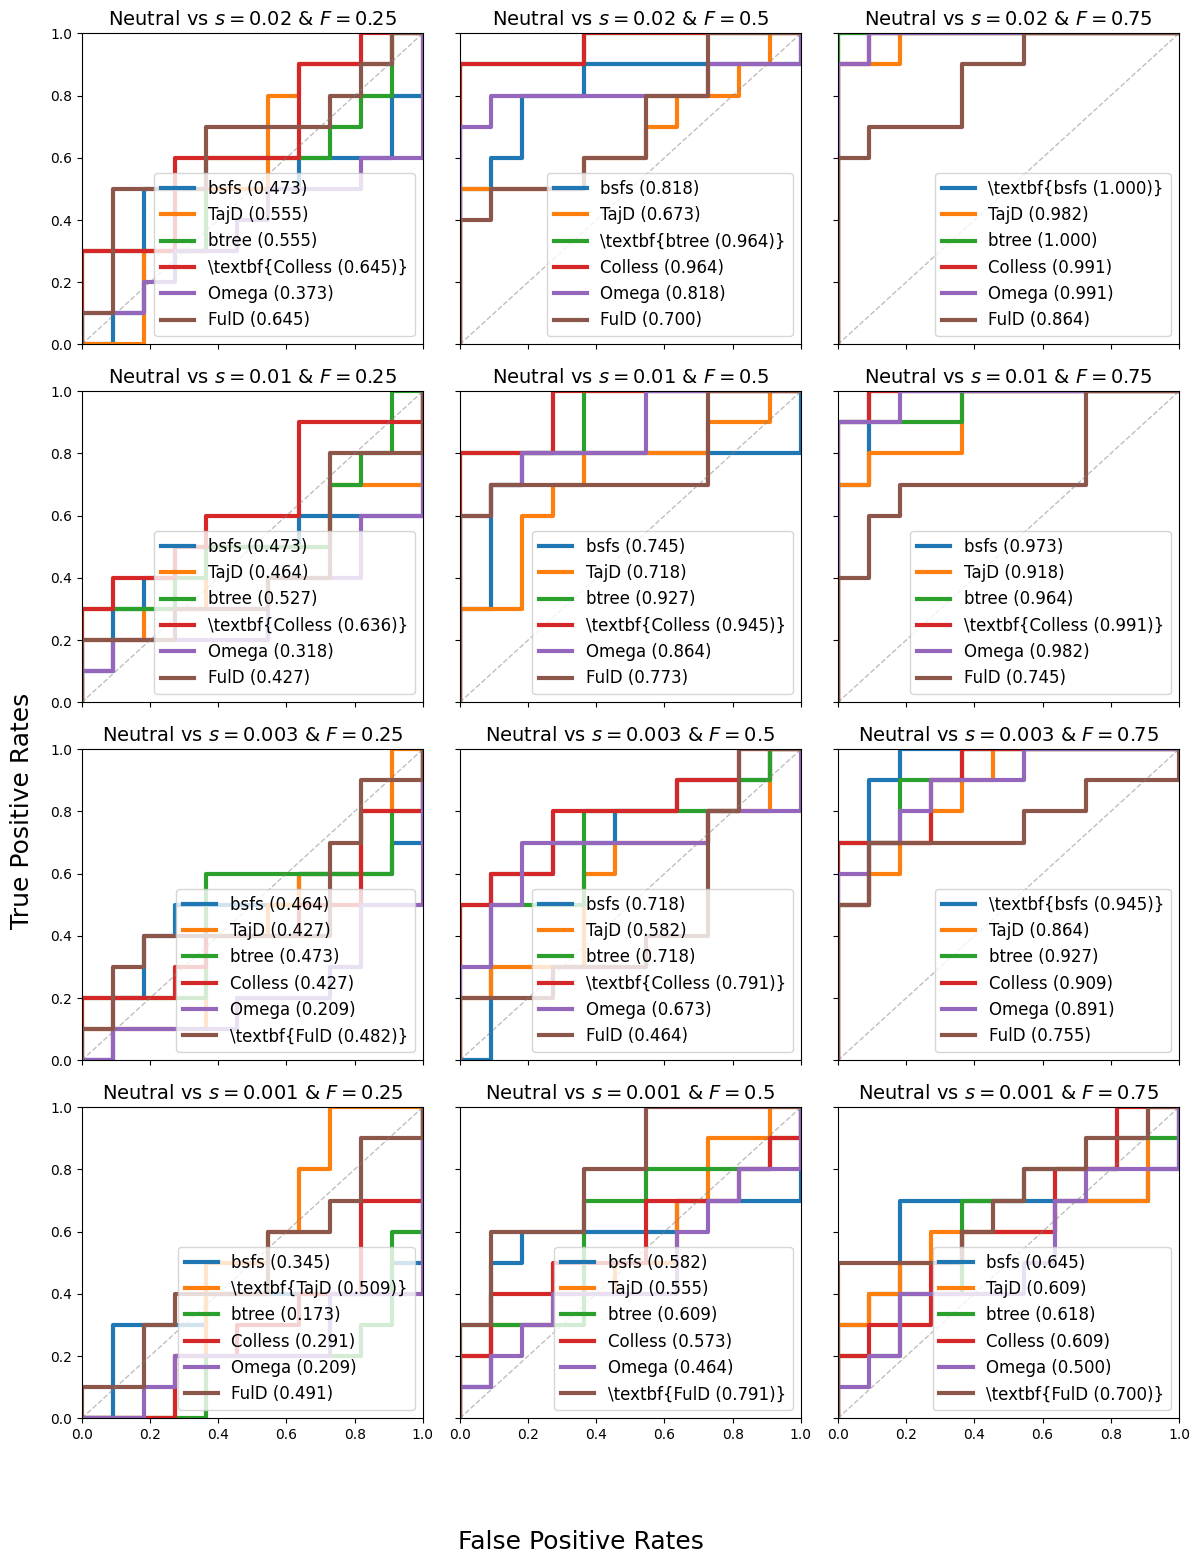

In [24]:
# If you had ROCAUC() earlier (from your PSlim helpers), reuse it.
# Otherwise, uncomment this local version:
from sklearn.metrics import roc_curve, roc_auc_score
def ROCAUC(y0, y1, score_ascending=False):
    if not score_ascending:
        # negate both so that "larger" means more positive class
        y0 = -np.asarray(y0)
        y1 = -np.asarray(y1)
    y_true = np.r_[np.zeros(len(y0)), np.ones(len(y1))]
    y_score = np.r_[y0, y1]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return fpr, tpr, roc_auc_score(y_true, y_score)

# Stats we’ll compare (present in your files)
stats = ['bsfs', 'TajD', 'btree', 'Colless', 'Omega', 'FulD']
# Order for legend (tweak if you want another ordering)
myorder = [0, 1, 2, 3, 4, 5]

# Load neutral set once
neutral_key = 'Fn'
df_neu = pd.read_csv(X.df[neutral_key]).dropna()

# Flip signs to match original intent (they flipped iColless and FulD)
def align_signs(df):
    df = df.copy()
    if 'Colless' in df.columns:
        df['Colless'] = -df['Colless']
    if 'FulD' in df.columns:
        df['FulD'] = -df['FulD']
    return df

df_neu = align_signs(df_neu)

fprs, tprs, aucs, blds = {}, {}, {}, {}

# build pairings: neutral vs each selection combo
names = []
pairs = []
for s in [0.02, 0.01, 0.003, 0.001]:
    for F in [0.25, 0.5, 0.75]:
        k2 = f"s={s}F={F}"
        if k2 in X.df and os.path.exists(X.df[k2]):
            pairs.append((neutral_key, k2))
            names.append(f"Neutral vs $s={s}$ & $F={F}$")

for name, (k1, k2) in zip(names, pairs):
    df1 = df_neu
    df2 = pd.read_csv(X.df[k2]).dropna()
    df2 = align_signs(df2)

    max_auc = -1
    best_key = None

    for key in stats:
        if key not in df1.columns or key not in df2.columns:
            continue
        fpr, tpr, auc = ROCAUC(df1[key], df2[key], score_ascending=False)
        fprs[(key, name)] = fpr
        tprs[(key, name)] = tpr
        aucs[(key, name)] = auc
        if auc > max_auc:
            max_auc = auc
            best_key = key
    blds[name] = best_key

# Plot (4×3 like original if you have 12 panels; adapt rows/cols to len(names))
ncols = 3
nrows = int(np.ceil(len(names)/ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(13, 5 + 3*nrows), sharex=True, sharey=True)
if nrows == 1:
    ax = np.array([ax])  # make 2D for consistent indexing

for i, name in enumerate(names):
    c, r = i % ncols, i // ncols
    for key in stats:
        if (key, name) not in fprs:
            continue
        fpr = fprs[(key, name)]
        tpr = tprs[(key, name)]
        auc = aucs[(key, name)]

        label_map = {'btree':'btree', 'Colless':'Colless', 'Omega':'Omega',
                     'bsfs':'bsfs', 'TajD':'TajD', 'FulD':'FulD'}
        label = f"{label_map.get(key, key)} ({auc:.3f})"

        if blds[name] == key:
            label = r"\textbf{" + label + "}"

        ax[r, c].plot(fpr, tpr, label=label, linewidth=3)

    ax[r, c].set_title(name, size=14)
    # Order legend entries
    handles, labels = ax[r, c].get_legend_handles_labels()
    if handles:
        order = [i for i in myorder if i < len(handles)]
        ax[r, c].legend([handles[_] for _ in order], [labels[_] for _ in order],
                        loc='lower right', prop={'size': 12})

for a in ax.ravel():
    a.set_xlim(0, 1); a.set_ylim(0, 1)
    a.plot([0,1], [0,1], ls='--', lw=1, color='gray', alpha=0.5)

fig.text(0.5, 0.07, 'False Positive Rates', ha='center', va='center', size=18)
fig.text(0.07, 0.5, 'True Positive Rates', rotation=90, ha='center', va='center', size=18)
plt.tight_layout(rect=[0.08, 0.12, 0.98, 0.98])
# plt.savefig('plots/Constant_Directional_no_infer.pdf', dpi=600, bbox_inches='tight')
plt.show()


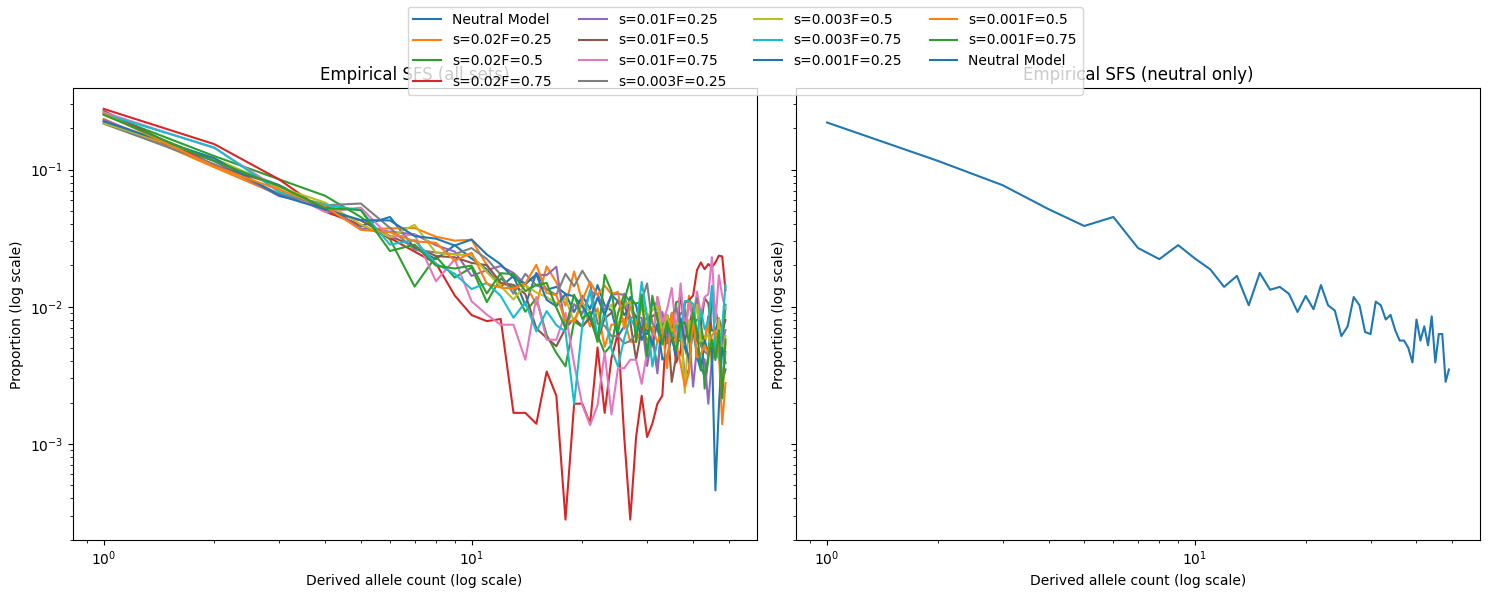

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

# left: all sets’ SFS
for setid in X.setids:
    name = Args[setid]['name']
    sfs = X.AFS[setid] / X.AFS[setid].sum()
    ax[0].plot(range(1, len(sfs)+1), sfs, label=name)

# right: just neutrals (empirical only; no ebl)
for setid in X.neutrals:
    sfs = X.AFS[setid] / X.AFS[setid].sum()
    ax[1].plot(range(1, len(sfs)+1), sfs, label=Args[setid]['name'])

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_xlabel('Derived allele count (log scale)')
    a.set_ylabel('Proportion (log scale)')

ax[0].set_title('Empirical SFS (all sets)')
ax[1].set_title('Empirical SFS (neutral only)')
fig.legend(ncol=4, loc='upper center')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
